In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
%cd /content/drive/MyDrive/Projects/synthetic-driver-distraction-augmentation
%ls

/content/drive/MyDrive/Projects/synthetic-driver-distraction-augmentation
car-driving.jpg
Driver_Augmentation_Colab.ipynb
Driver_Augmentation_Colab_old.ipynb
hands-wheel-when-driving-high-speed-from-inside-car_169016-22978.avif
images.jpeg
main.py
pipeline/
pyproject.toml
README.md


Cell 1 — Install dependencies (T4-friendly)


In [7]:
# Install dependencies (avoid forcing torch reinstall)
!pip install -q --upgrade diffusers transformers accelerate opencv-python controlnet_aux safetensors xformers

Cell 2 — Imports + device setup

In [8]:
import os
import json
import math
import time
import random
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple

import torch
import torch.nn.functional as F
from PIL import Image

from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from transformers import CLIPProcessor, CLIPModel

from controlnet_aux import OpenposeDetector

Cell 3 — Core class (OpenPose → SD+ControlNet → CLIP validation)

In [9]:
class SyntheticDriverAugmentor:
    """
    Stage 1: OpenPose conditioning (ControlNet image)
    Stage 2: SD 1.5 generation with ControlNet(OpenPose)
    Stage 3: CLIP cosine similarity validation
    """

    def __init__(
        self,
        sd_model_id: str = "runwayml/stable-diffusion-v1-5",
        controlnet_id: str = "lllyasviel/sd-controlnet-openpose",
        openpose_aux_id: str = "lllyasviel/ControlNet",
        clip_model_id: str = "openai/clip-vit-base-patch32",
    ):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.dtype = torch.float16 if self.device == "cuda" else torch.float32

        # Stage 1: OpenPose detector -> pose map (PIL)
        self.openpose = OpenposeDetector.from_pretrained(openpose_aux_id)

        # Stage 1/2: ControlNet + SD 1.5
        controlnet = ControlNetModel.from_pretrained(controlnet_id, torch_dtype=self.dtype)
        self.pipe = StableDiffusionControlNetPipeline.from_pretrained(
            sd_model_id,
            controlnet=controlnet,
            torch_dtype=self.dtype,
            safety_checker=None,            # optional, speeds up; remove if you want it
            requires_safety_checker=False,
        ).to(self.device)

        # T4 optimizations
        try:
            self.pipe.enable_xformers_memory_efficient_attention()
        except Exception:
            pass
        self.pipe.enable_attention_slicing()
        self.pipe.enable_vae_slicing()

        # Stage 3: CLIP
        self.clip_model = CLIPModel.from_pretrained(clip_model_id).to(self.device)
        self.clip_processor = CLIPProcessor.from_pretrained(clip_model_id)

    def make_pose_map(self, seed_image: Image.Image, size: Tuple[int, int] = (512, 512)) -> Image.Image:
        seed_image = seed_image.convert("RGB").resize(size)
        pose_map = self.openpose(seed_image)  # returns PIL image
        return pose_map

    def generate(
        self,
        prompt: str,
        seed_image: Image.Image,
        negative_prompt: Optional[str] = None,
        steps: int = 25,
        guidance: float = 7.0,
        control_scale: float = 1.0,
        size: Tuple[int, int] = (512, 512),
        seed: Optional[int] = None,
    ) -> Tuple[Image.Image, Image.Image]:
        """
        Returns (generated_image, pose_map).
        """
        pose_map = self.make_pose_map(seed_image, size=size)

        generator = None
        if seed is not None:
            generator = torch.Generator(device=self.device).manual_seed(seed)

        out = self.pipe(
            prompt=prompt,
            negative_prompt=negative_prompt,
            image=pose_map,  # ControlNet conditioning image (NOT None)
            num_inference_steps=steps,
            guidance_scale=guidance,
            controlnet_conditioning_scale=control_scale,
            generator=generator,
        )
        return out.images[0], pose_map

    def clip_similarity(self, image: Image.Image, prompt: str) -> float:
        """
        Cosine similarity between normalized CLIP embeddings. Typical range ~[-1, 1].
        """
        inputs = self.clip_processor(
            text=[prompt],
            images=image,
            return_tensors="pt",
            padding=True,
        ).to(self.device)

        with torch.no_grad():
            outputs = self.clip_model(**inputs)
            img_emb = F.normalize(outputs.image_embeds, dim=-1)
            txt_emb = F.normalize(outputs.text_embeds, dim=-1)
            sim = (img_emb * txt_emb).sum(dim=-1).item()

        return sim

Cell 4 — Upload a seed “in-cabin” image (required)
This image provides the driver anatomy/pose for OpenPose.

In [ ]:
import glob
#from PIL import Image

PROJECT_DIR = "/content/drive/MyDrive/synthetic-driver-distraction-augmentation"  # change if needed
SEED_DIR = os.path.join(PROJECT_DIR, "seeds")  # put multiple .jpg/.png here

seed_paths = sorted(
    glob.glob(os.path.join(SEED_DIR, "*.jpg")) +
    glob.glob(os.path.join(SEED_DIR, "*.jpeg")) +
    glob.glob(os.path.join(SEED_DIR, "*.png"))
)

if not seed_paths:
    raise FileNotFoundError(f"No seed images found in {SEED_DIR}")

print(f"Found {len(seed_paths)} seed images")
print(seed_paths[:5])

In [22]:
from google.colab import files

uploaded = files.upload()  # upload a single jpg/png (in-cabin driver)
seed_path = next(iter(uploaded.keys()))
seed_image = Image.open(seed_path).convert("RGB")
seed_image

Output hidden; open in https://colab.research.google.com to view.

Cell 5 — Initialize augmentor + sanity check pose map

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

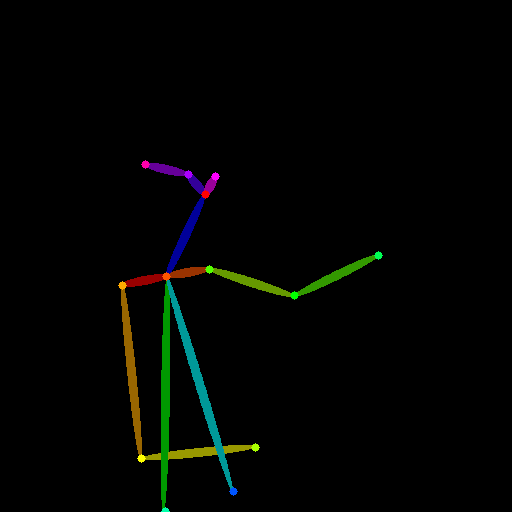

In [23]:
augmentor = SyntheticDriverAugmentor()

pose_map = augmentor.make_pose_map(seed_image)
pose_map

Cell 6 — Single prompt generation demo + CLIP score

  0%|          | 0/25 [00:00<?, ?it/s]

CLIP cosine similarity: 0.26915132999420166


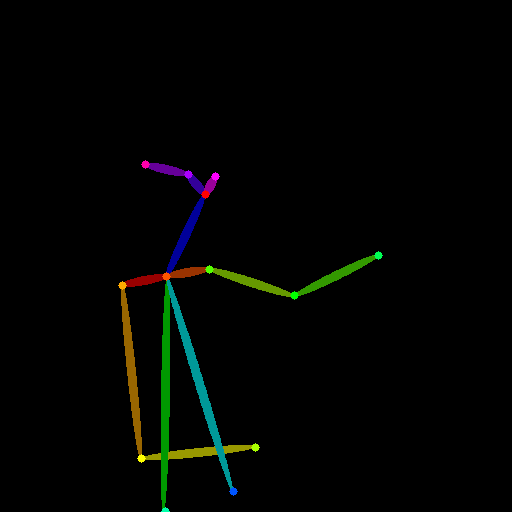

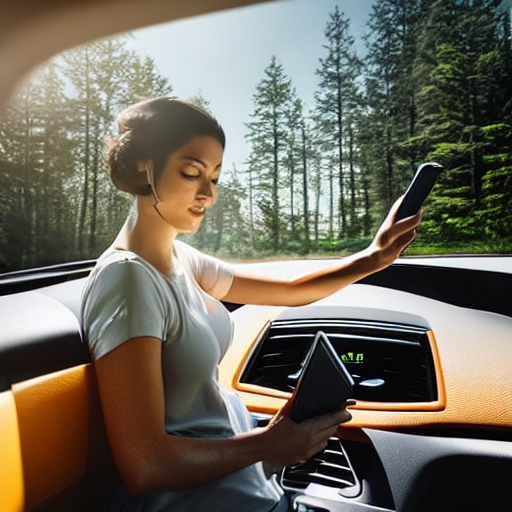

In [24]:
prompt = "driver using a phone while seated in a car, in-cabin camera view, realistic lighting"
negative = "extra limbs, deformed hands, bad anatomy, duplicate person, blurry, low quality"

gen_img, pose_map = augmentor.generate(
    prompt=prompt,
    seed_image=seed_image,
    negative_prompt=negative,
    steps=25,
    guidance=7.0,
    control_scale=1.0,
    seed=42
)

score = augmentor.clip_similarity(gen_img, prompt)

print("CLIP cosine similarity:", score)
display(pose_map)
display(gen_img)

Cell 7 — Balanced dataset loop (N images per scenario) + filtering
This generates a balanced dataset across scenarios: **bold text**same n_per_scenario each.

In [25]:
scenarios = [
    "driver eating a sandwich while seated in a car, in-cabin camera, realistic",
    "driver drinking coffee while seated in a car, in-cabin camera, realistic",
    "driver using a phone while seated in a car, in-cabin camera, realistic",
    "driver adjusting the radio while seated in a car, in-cabin camera, realistic",
]

negative = "extra limbs, deformed hands, bad anatomy, duplicate person, blurry, low quality"

n_per_scenario = 5
clip_threshold = 0.25   # adjust: higher => stricter filtering
max_attempts_per_image = 6

out_dir = "outputs"
os.makedirs(out_dir, exist_ok=True)

manifest = []

global_idx = 0
for scenario in scenarios:
    accepted = 0
    attempts = 0

    while accepted < n_per_scenario and attempts < n_per_scenario * max_attempts_per_image:
        attempts += 1
        seed = random.randint(0, 2**31 - 1)

        img, pose = augmentor.generate(
            prompt=scenario,
            seed_image=seed_image,
            negative_prompt=negative,
            steps=25,
            guidance=7.0,
            control_scale=1.0,
            seed=seed,
        )

        sim = augmentor.clip_similarity(img, scenario)

        if sim < clip_threshold:
            continue

        # Save
        sample_id = f"{global_idx:06d}"
        img_path = os.path.join(out_dir, f"{sample_id}.png")
        pose_path = os.path.join(out_dir, f"{sample_id}_pose.png")

        img.save(img_path)
        pose.save(pose_path)

        manifest.append({
            "id": sample_id,
            "prompt": scenario,
            "clip_cosine_similarity": sim,
            "image_path": img_path,
            "pose_path": pose_path,
            "seed": seed,
        })

        accepted += 1
        global_idx += 1

    print(f"[{scenario}] accepted {accepted}/{n_per_scenario} (attempts={attempts})")

manifest_path = os.path.join(out_dir, "manifest.json")
with open(manifest_path, "w") as f:
    json.dump(manifest, f, indent=2)

print("Saved:", manifest_path)
print("Total accepted:", len(manifest))

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[driver eating a sandwich while seated in a car, in-cabin camera, realistic] accepted 5/5 (attempts=5)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[driver drinking coffee while seated in a car, in-cabin camera, realistic] accepted 5/5 (attempts=6)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[driver using a phone while seated in a car, in-cabin camera, realistic] accepted 5/5 (attempts=5)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

[driver adjusting the radio while seated in a car, in-cabin camera, realistic] accepted 5/5 (attempts=5)
Saved: outputs/manifest.json
Total accepted: 20


**Cell 8 — Quick view of a few saved samples**




In [26]:
import glob
from IPython.display import display

paths = sorted(glob.glob("outputs/*.png"))
for p in paths[:]:
    if p.endswith("_pose.png"):
        continue
    display(Image.open(p))

Output hidden; open in https://colab.research.google.com to view.

Evaluation matrix


In [27]:
import json, os
import numpy as np
from collections import defaultdict

manifest_path = "outputs/manifest.json"
if not os.path.exists(manifest_path):
    raise FileNotFoundError(f"Not found: {manifest_path}. Run the generation loop first.")

with open(manifest_path, "r") as f:
    manifest = json.load(f)

by_prompt = defaultdict(list)
for row in manifest:
    by_prompt[row["prompt"]].append(row["clip_cosine_similarity"])

def summarize(vals):
    arr = np.array(vals, dtype=np.float32)
    return {
        "n": int(arr.size),
        "mean": float(arr.mean()) if arr.size else None,
        "median": float(np.median(arr)) if arr.size else None,
        "std": float(arr.std(ddof=0)) if arr.size else None,
        "min": float(arr.min()) if arr.size else None,
        "max": float(arr.max()) if arr.size else None,
    }

print("=== Dataset Evaluation Report ===")
print(f"Total accepted samples: {len(manifest)}")
print()

for prompt, vals in by_prompt.items():
    s = summarize(vals)
    print(f"PROMPT: {prompt}")
    print(f"  n={s['n']}  mean={s['mean']:.3f}  median={s['median']:.3f}  std={s['std']:.3f}  min={s['min']:.3f}  max={s['max']:.3f}")

=== Dataset Evaluation Report ===
Total accepted samples: 20

PROMPT: driver eating a sandwich while seated in a car, in-cabin camera, realistic
  n=5  mean=0.294  median=0.286  std=0.011  min=0.284  max=0.313
PROMPT: driver drinking coffee while seated in a car, in-cabin camera, realistic
  n=5  mean=0.286  median=0.264  std=0.031  min=0.260  max=0.339
PROMPT: driver using a phone while seated in a car, in-cabin camera, realistic
  n=5  mean=0.272  median=0.271  std=0.014  min=0.254  max=0.292
PROMPT: driver adjusting the radio while seated in a car, in-cabin camera, realistic
  n=5  mean=0.262  median=0.263  std=0.005  min=0.255  max=0.269


In [15]:
%ls

car-driving.jpg                      images.jpeg  pipeline/       seed.jpeg
Driver_Augmentation_Colab.ipynb      main.py      pyproject.toml  seed.jpg
Driver_Augmentation_Colab_old.ipynb  outputs/     README.md
